<a href="https://colab.research.google.com/github/AyushMaria/Vortex-Detection/blob/main/Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# importing linear algebra
import numpy as np 

# importing tools for data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd 

# importing the tools to call google drive
from google.colab import drive

# importing seaborn
import seaborn as sns

from sklearn.model_selection import GridSearchCV

# import train_test_split function
from sklearn.model_selection import train_test_split

# import the Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# Import the AdaBoost classifier
from sklearn.ensemble import AdaBoostClassifier

# Import the XGBoost Classifier 
from xgboost import XGBClassifier

# Import joblib to save machine learning model
import joblib

# Import the Voting CLassifier
from sklearn.ensemble import VotingClassifier

# Importing the necessary tools to check how the clasifiers performed
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 

# import the required metrics to plot validation curve
from sklearn.model_selection import validation_curve

# import the plotting library to visualize our learning curve
import matplotlib.pyplot as plt

In [7]:
# mount our directory
mount='/content/gdrive'
drive.mount(mount, force_remount=True)

Mounted at /content/gdrive


In [8]:
# Switch to the directory on the VM for our purposes
drive_root=mount + '/My Drive/Colab Notebooks/Object Detection'
%cd $drive_root
%pwd

/content/gdrive/My Drive/Colab Notebooks/Object Detection


'/content/gdrive/My Drive/Colab Notebooks/Object Detection'

In [9]:
# Importing the image feature dataset for the classifier
data = pd.read_csv('final.csv')

# dropping the rows with null values
train=data.dropna()

# creating a column which consists of row numbers 
train.insert(loc=0, column='row_num', value=np.arange(len(train)))

# dropping irrelevant features
train=train.drop(columns=['ID','localX', 'localY'])

In [10]:
predictions = pd.DataFrame(columns = ['contourArea','areaPercDiff','aspectRatio','momentLocDiff'])

In [11]:
# Assigning the important features to X 
X = train[['contourArea','areaPercDiff','aspectRatio','momentLocDiff']]

In [12]:
# Assigning the label values to y
y = train['label']

In [13]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
xg_param = {
    "n_estimators": [50, 100],
    "random_state": [0,1],
    "max_depth" : [2,3],
    "learning_rate" :[0.5,0.7]
}
rf_param = {
    "n_estimators": [50, 100],
    "random_state": [0,1],
    "max_depth" : [2,3]
}

abc_param = {
    "n_estimators": [50, 100],
    "random_state": [0,1],
    "learning_rate" :[0.5,0.7]
}


params = {}
params.update({"xg__" + k: v for k, v in xg_param.items()})
params.update({"rf__" + k: v for k, v in rf_param.items()})
params.update({"abc__" + k: v for k, v in abc_param.items()})

xg = XGBClassifier()
rf = RandomForestClassifier()
abc= AdaBoostClassifier()
eclf = VotingClassifier(estimators=[("xg", xg),("rf", rf),("abc", abc)],voting="hard")


grid = GridSearchCV(estimator=eclf, param_grid=params, cv=2)

grid.fit(X_train,y_train)
print (grid.best_params_)

In [ ]:
# Creating classifer objects and assigning them with the appropriate parameters
clf1 = AdaBoostClassifier(n_estimators=50, learning_rate=0.5, random_state=0)
clf2 = RandomForestClassifier(n_estimators=50, max_depth=3, random_state=0)
clf3 = XGBClassifier(n_estimators=50, learning_rate=0.5, random_state=0, max_depth=2)

# Training the Classifers using the fit method
model1 = clf1.fit(X_train, y_train)
model2 = clf2.fit(X_train, y_train)
model3 = clf3.fit(X_train, y_train)

# Assigning the fitted models to the voting classifier and then fitting the voting classifier
eclf = VotingClassifier( estimators=[('abc', model1), ('rf', model2), ('xgb', model3)],voting='hard')
model4 = eclf.fit(X_train, y_train)

# Determining the accuracy of each model 
y_pred = model4.predict(X_test)
print(model4, accuracy_score(y_test, y_pred))

In [21]:
y_pred = votingclassifier_from_joblib.predict(X_test)
print(votingclassifier_from_joblib, accuracy_score(y_test, y_pred))

VotingClassifier(estimators=[('abc',
                              AdaBoostClassifier(learning_rate=0.5,
                                                 random_state=0)),
                             ('rf',
                              RandomForestClassifier(max_depth=3,
                                                     n_estimators=50,
                                                     random_state=0)),
                             ('xgb',
                              XGBClassifier(learning_rate=0.5, max_depth=2,
                                            missing=nan, n_estimators=50))]) 0.975609756097561


In [ ]:
# Save the model as a pickle in a file
joblib.dump(model4, 'Voting Classifier.pkl')

['Voting Classifier.pkl']

In [19]:
from sklearn import metrics
report = metrics.classification_report(y_test, y_pred, output_dict=True)
df_classification_report = pd.DataFrame(report).transpose()
df_classification_report = df_classification_report.sort_values(by=['f1-score'], ascending=False)
df_classification_report

,precision,recall,f1-score,support
no_vortex,1.000000,0.952381,0.97561,21.00000
vortex,0.952381,1.000000,0.97561,20.00000
accuracy,0.975610,0.975610,0.97561,0.97561
macro avg,0.976190,0.976190,0.97561,41.00000
weighted avg,0.976771,0.975610,0.97561,41.00000


In [16]:
# Load the model from the file
votingclassifier_from_joblib = joblib.load('Voting Classifier.pkl')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


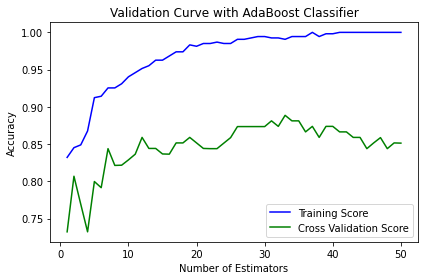

In [ ]:
# arranging the parameters that have to be tested
param_range = np.arange(1, 51)

# obtaining the training and the testing scores to plot on the graph

train_score, test_score = validation_curve(model1, X, y, param_name = "n_estimators", param_range=param_range, cv = 5, scoring = "accuracy")
 
# Calculating the mean and the standard deviation of the training score
mean_training_score = np.mean(train_score, axis = 1)
std_training_score = np.std(train_score, axis = 1)
 
# Calculating the mean and the standard deviation of the testing score
mean_testing_score = np.mean(test_score, axis = 1)
std_testing_score = np.std(test_score, axis = 1)
 
# Plot the mean accuracy scores for the training and testing scores
plt.plot(param_range, mean_training_score, label = "Training Score", color = 'b')
plt.plot(param_range, mean_testing_score, label = "Cross Validation Score", color = 'g')
 
# Creating the plot
plt.title("Validation Curve with AdaBoost Classifier")
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

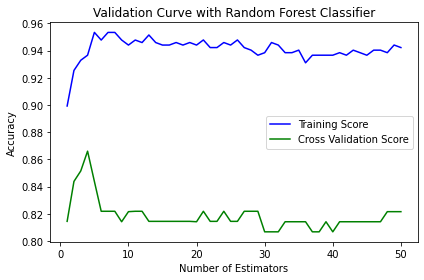

In [ ]:
# arranging the parameters that have to be tested
param_range = np.arange(1, 51)

# obtaining the training and the testing scores to plot on the graph

train_score, test_score = validation_curve(model2, X, y, param_name = "n_estimators", param_range=param_range, cv = 5, scoring = "accuracy")
 
# Calculating the mean and the standard deviation of the training score
mean_training_score = np.mean(train_score, axis = 1)
std_training_score = np.std(train_score, axis = 1)
 
# Calculating the mean and the standard deviation of the testing score
mean_testing_score = np.mean(test_score, axis = 1)
std_testing_score = np.std(test_score, axis = 1)
 
# Plot the mean accuracy scores for the training and testing scores
plt.plot(param_range, mean_training_score, label = "Training Score", color = 'b')
plt.plot(param_range, mean_testing_score, label = "Cross Validation Score", color = 'g')
 
# Creating the plot
plt.title("Validation Curve with Random Forest Classifier")
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

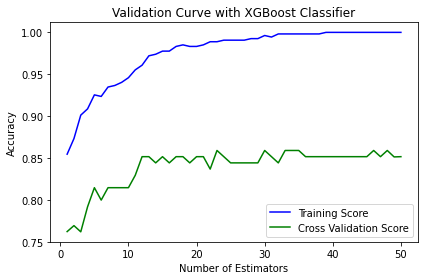

In [ ]:
# arranging the parameters that have to be tested
param_range = np.arange(1, 51)

# obtaining the training and the testing scores to plot on the graph

train_score, test_score = validation_curve(model3, X, y, param_name = "n_estimators", param_range=param_range, cv = 5, scoring = "accuracy")
 
# Calculating the mean and the standard deviation of the training score
mean_training_score = np.mean(train_score, axis = 1)
std_training_score = np.std(train_score, axis = 1)
 
# Calculating the mean and the standard deviation of the testing score
mean_testing_score = np.mean(test_score, axis = 1)
std_testing_score = np.std(test_score, axis = 1)
 
# Plot the mean accuracy scores for the training and testing scores
plt.plot(param_range, mean_training_score, label = "Training Score", color = 'b')
plt.plot(param_range, mean_testing_score, label = "Cross Validation Score", color = 'g')
 
# Creating the plot
plt.title("Validation Curve with XGBoost Classifier")
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

In [137]:
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

[[20  1]
 [ 0 20]]


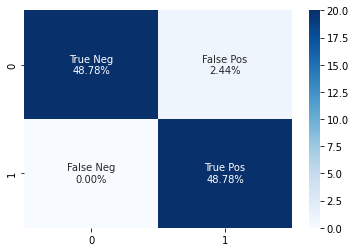

In [138]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
#group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [139]:
t_p, f_p, f_n, t_n = confusion_matrix(y_test, y_pred).ravel()
Accuracy = (t_p+t_n)*100/(t_p+t_n+f_p+f_n) 
print("Accuracy {:0.2f}%:",(Accuracy))

Accuracy {:0.2f}%: 97.5609756097561


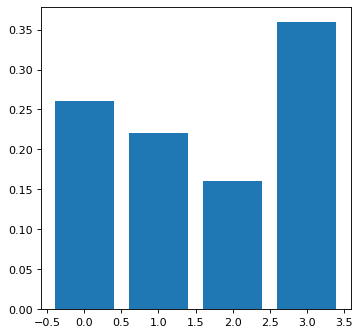

In [ ]:
importance = clf1.feature_importances_
plt.figure(figsize=(5,5), dpi= 80)
plt.bar([x for x in range(len(importance))], importance)
plt.show()

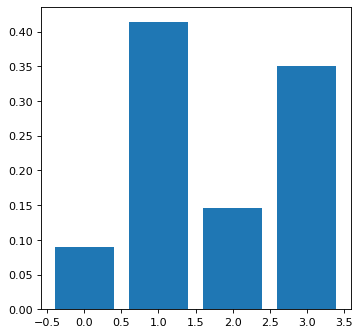

In [ ]:
importance = clf2.feature_importances_
plt.figure(figsize=(5,5), dpi= 80)
plt.bar([x for x in range(len(importance))], importance)
plt.show()

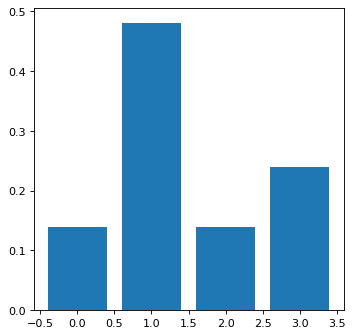

In [ ]:
importance = clf3.feature_importances_
plt.figure(figsize=(5,5), dpi= 80)
plt.bar([x for x in range(len(importance))], importance)
plt.show()